In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Resources/Parkingtickets_Dec2016.csv")
df.head()

,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Violation Time,Violation County,From Hours In Effect,To Hours In Effect,Vehicle Color,Vehicle Year,Meter Number,Violation Post Code,Violation Description
0,GYG8911,NY,PAS,12/18/2016,24,SUBN,JEEP,1204P,Q,NaN,NaN,BK,2015,NaN,15 4,24-No Parking (exc auth veh)
1,8P82H,NY,OMT,12/21/2016,14,TAXI,NISSA,1015A,NY,ALL,ALL,YELLO,2014,-,NaN,NaN
2,GML6346,NY,PAS,12/19/2016,21,SDN,HONDA,1212P,K,1130A,0100A,GREY,2013,-,NaN,NaN
3,12203MG,NY,COM,12/1/2016,46,VAN,FRUEH,1137A,NY,ALL,ALL,BROWN,2015,-,NaN,NaN
4,HEG7444,NY,PAS,12/1/2016,36,4DSD,BMW,1027A,BK,NaN,NaN,BK,2016,NaN,NaN,PHTO SCHOOL ZN SPEED VIOLATION


# Data Cleanup

In [3]:
# Removes DK (dark) and LT (light) demarkations for colors and drops any non-string values
for index, row in df.iterrows():
    try:
        if row["Vehicle Color"].startswith("D"):
            if row["Vehicle Color"].startswith("DK"):
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("DK")
            else:
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("D")
            
        elif row["Vehicle Color"].startswith("L"):
            if row["Vehicle Color"].startswith("LT"):
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("LT")
            else:
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("L")
        
    except AttributeError:
        df.drop(index, inplace=True)

In [4]:
# Defines standard color abbreviations as keys and irregular color abbreviations as values

colors_dict = {
    "Black": ('BLA', 'BK'),
    "Blue": ('BL', "NA"),
    "Brown": ('BR', 'BN'),
    "Gray": ("GY", "GRA", "GREY", "GRY", "GEY", "S", "CH", "CR"), # combines grays and silvers
    "Green": ("GRE", "GN", "GRN"),
    "Orange": "O",
    "Red": ("R", "BRG", "BUR", "M"), # combines reds, burgundies, and maroons
    "Tan": ("T", "BE", "BG", "BI"), # combines tans and beiges
    "White": "W",
    "Yellow": "Y"
}

# Loops through keys and changes irregular abbreviations to standard
for color in colors_dict:
    df["Vehicle Color"].loc[df['Vehicle Color'].str.startswith(colors_dict[color], na=False)==True] = color

C:\Users\Elliott\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# Shows new color groupings
df['Vehicle Color'].value_counts()

Black     8423
Gray      7767
White     7753
Blue      2479
Red       1611
Brown      955
Yellow     526
GR         274
Tan        187
Orange     182
Green       68
G           54
GL          39
/           26
PR          22
GOLD        13
B           11
PURPL        8
UNKNO        6
NOCL         4
UNK          4
PLE          2
P            1
GLBR         1
XXX          1
CL           1
AVEN         1
FREIG        1
HONDA        1
NOC          1
CM           1
Name: Vehicle Color, dtype: int64

# Plots

In [6]:
# Groups all colors outside top 10 as "Other"
color_df = df['Vehicle Color'].value_counts().rename_axis("Colors").reset_index(name='Num Cars')

other_total = 0

for i, r in color_df.iterrows():
    if r['Colors'] not in colors_dict.keys():
        other_total += r['Num Cars']
        color_df.drop(i, inplace=True)

other = pd.DataFrame({
    'Colors': ['Other'],
    'Num Cars': other_total
})
color_df = pd.concat([color_df, other])
color_df

,Colors,Num Cars
0,Black,8423
1,Gray,7767
2,White,7753
3,Blue,2479
4,Red,1611
5,Brown,955
6,Yellow,526
8,Tan,187
9,Orange,182
10,Green,68


In [7]:
colors = [c if c!='Other' else 'purple' for c in color_df['Colors']]
colors

['Black',
 'Gray',
 'White',
 'Blue',
 'Red',
 'Brown',
 'Yellow',
 'Tan',
 'Orange',
 'Green',
 'purple']

([<matplotlib.patches.Wedge at 0x1cd49bf3220>,
 [Text(-0.7094853934228699, -0.840613155095491, 'Black'),
  Text(0.9078925214592289, -0.6210725959808594, 'Gray'),
  Text(0.591839828340555, 0.9272139006668432, 'White'),
  Text(-0.5162212390638857, 0.9713473283740202, 'Blue'),
  Text(-0.8690192551552248, 0.6743927150922218, 'Red'),
  Text(-1.0153029801713978, 0.42327279437152404, 'Brown'),
  Text(-1.0679333920456262, 0.2636631755742978, 'Yellow'),
  Text(-1.0844353030147007, 0.18439108865510387, 'Tan'),
  Text(-1.0906725279177965, 0.14294557301785815, 'Orange'),
  Text(-1.0939989656258806, 0.1147443384638377, 'Green'),
  Text(-1.098693646610183, 0.053593571428096655, 'Other')],
 [Text(-0.3869920327761108, -0.4585162664157223, '27.7%'),
  Text(0.4952141026141248, -0.33876687053501414, '25.5%'),
  Text(0.3228217245493936, 0.5057530367273689, '25.5%'),
  Text(-0.281575221307574, 0.5298258154767382, '8.1%'),
  Text(-0.47401050281194074, 0.3678505718684845, '5.3%'),
  Text(-0.553801625548035, 

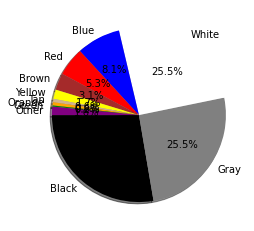

In [8]:
plt.pie(color_df['Num Cars'],
        labels=color_df['Colors'],
        colors=colors,
        shadow=True,
        autopct='%1.1f%%',
        startangle=180
       )